In [1]:
import numpy as np
import pandas as pd
import pickle


from matplotlib import pyplot as plt
%matplotlib inline 

from utils.train_conformal import train_conformal_forecaster

In [ ]:
# Dataset size
# n_train_samples = 1000
# n_calibration_samples = 1000
# n_test_samples = 500

# Time series parameters
seq_len = 10
horizon = 5
noise_profile = None
periodicity = 2
amplitude = 1
dynamic_sequence_lengths=False

# LSTM parameters
epochs=4000
batch_size=100
embedding_size=20
coverage=0.9
lr=0.01


In [ ]:
def run_synthetic_experiments(exp_mode, params, coverage, seq_len,
                              n_train_seq, n_test_seq, retrain=False):
    
    baselines           = ["BJRNN", "QRNN", "DPRNN"]
    exp_res_dict        = dict({"BJRNN": [], "QRNN": [], "DPRNN": []})
    baseline_results    = dict({"BJRNN": dict({"CI_length": None, "Errors": None,  "Coverages": None, }), 
                                "QRNN": dict({"CI_length": None, "Errors": None,  "Coverages": None, }), 
                                "DPRNN": dict({"CI_length": None, "Errors": None,  "Coverages": None, })})
    
    if exp_mode=="2":
        
        n_samples_          = [10, 100, 1000]
        noise_var_          = 0.2
        
        if retrain:
    
            for n_sample_ in n_samples_:

                exp_results     = collect_synthetic_results(noise_var_, params, coverage=coverage, seq_len=seq_len,
                                                            n_train_seq=n_train_seq, n_test_seq=n_test_seq)

                exp_res_dict["BJRNN"].append(exp_results["BJRNN"])
                exp_res_dict["QRNN"].append(exp_results["QRNN"])
                exp_res_dict["DPRNN"].append(exp_results["DPRNN"])
        else:
            
            infile              = open('saved_models/Experiment_2_result','rb')
            exp_res_dict        = pickle.load(infile)
            
    elif exp_mode=="1":
            
        noise_vars          = [0.1 * k for k in range(9)]    
        
        if retrain:
            
            for noise_var in noise_vars:

                exp_results   = collect_synthetic_results(noise_var, params, coverage=coverage, seq_len=seq_len,
                                                          n_train_seq=n_samples, n_test_seq=n_test)

                exp_res_dict["BJRNN"].append(exp_results["BJRNN"])
                exp_res_dict["QRNN"].append(exp_results["QRNN"])
                exp_res_dict["DPRNN"].append(exp_results["DPRNN"])
        
        else:
            
            infile              = open('saved_models/Experiment_1_result','rb')
            exp_res_dict        = pickle.load(infile)
        
        
    for baseline in baselines:
        
        baseline_results[baseline]["CI_length"] = [exp_res_dict[baseline][k][0]["CI length"] for k in range(len(exp_res_dict[baseline]))]
        baseline_results[baseline]["Errors"]    = [np.mean(np.concatenate(exp_res_dict[baseline][k][0]["Errors"])) for k in range(len(exp_res_dict[baseline]))]
        baseline_results[baseline]["Coverages"] = BJRNN_coverages = [exp_res_dict[baseline][k][0]["Coverage"] for k in range(len(exp_res_dict[baseline]))]
    
    return baseline_results

## Data processing

In [2]:
df = pd.read_csv('data/energy_data.csv')

In [3]:
df

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,...,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,...,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,...,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,...,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,...,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,...,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,...,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,...,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,...,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784


In [4]:
df.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

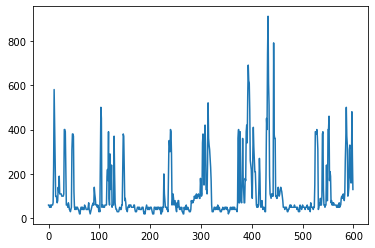

In [21]:
plt.plot(df['Appliances'][:600])

In [30]:
df_stock = pd.read_csv('data/stock_data.csv')

In [31]:
df_stock

,Open,High,Low,Close,Adj_Close,Volume
0,49.676899,51.693783,47.669952,49.845802,49.845802,44994500
1,50.178635,54.187561,49.925285,53.805050,53.805050,23005800
2,55.017166,56.373344,54.172661,54.346527,54.346527,18393200
3,55.260582,55.439419,51.450363,52.096165,52.096165,15361800
4,52.140873,53.651051,51.604362,52.657513,52.657513,9257400
...,...,...,...,...,...,...
3680,1207.479980,1216.300049,1200.500000,1205.920044,1205.920044,1017800
3681,1205.939941,1215.670044,1204.130005,1215.000000,1215.000000,950000
3682,1214.989990,1216.219971,1205.030029,1207.150024,1207.150024,907200
3683,1207.890015,1208.689941,1199.859985,1203.839966,1203.839966,860200


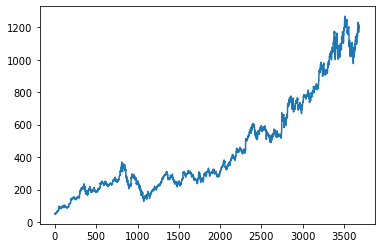

In [37]:
plt.plot(df_stock['Close'])

In [75]:
(len(df_stock['Close']) - 30 - 10) // 1

3645

Energy data
* Predicting the `Appliances` variable
* Splitting the sequence with $T=600$ (10 hours) and $H=120$ (2 hours)
* Best is maybe 3826 sequences with stride 5
* Split: 500 test, 2000 train 1330 calibration sequences; the test subsequences are the last ones of the full series

Stock data
* Predicting the `Close` price of ?? stock
* Splitting at higher granularity: $T=30$ and $H=10$ (month and 10 days)
* With offset=1, results in 3655 sequences; 500 for testing, 2000 train and 1155 calibration

Hungarian chickenpox data
* Predicting the weekly number of cases
* Train on most regions and choose other regions for testing (this can fail because different regions can follow different distributions)
* Choose $T=8$, $H=4$ (given past two months, what is the forecast for the next month)

In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
from utils.uci_data_processing import prepare_uci_datasets

In [26]:
prepare_uci_datasets()

Dataset: energy, calibrated: True
Dataset: energy, calibrated: False
Dataset: stock, calibrated: True
Dataset: stock, calibrated: False
Dataset: hungary, calibrated: True
Dataset: hungary, calibrated: False


In [27]:
from models.conformal import ConformalForecaster
from utils.uci_data_processing import run_uci_experiments

In [30]:
from utils.uci_data_processing import run_uci_experiments
run_uci_experiments(datasets=['hungary'], baselines=['DPRNN'], retrain=True)

DPRNN, hungary


TypeError: super(type, obj): obj must be an instance or subtype of type

In [44]:
from models.conformal import ConformalForecaster
ConformalForecaster(20)

ConformalForecaster(
  (forecaster_rnn): LSTM(1, 20, batch_first=True)
  (forecaster_out): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
from models.dp

In [5]:
import pandas as pd
from utils.uci_data_processing import get_multi_feature_windows

In [9]:
calibrate=True
length, stride, horizon = None, None, None
return_raw = not calibrate

In [10]:
df = pd.read_csv('data/hungary_chickenpox/hungary_chickenpox.csv')
length = 8 if length is None else length
stride = 1 if stride is None else stride
horizon = 4 if horizon is None else horizon

if calibrate:
    train_features = ['BUDAPEST', 'BACS', 'BEKES', 'BORSOD', 'CSONGRAD',
                      'HAJDU', 'HEVES', 'JASZ',
                      'NOGRAD', 'PEST', 'SZABOLCS']
    cal_features = ['KOMAROM', 'GYOR', 'VESZPREM', 'TOLNA', 'FEJER']
else:
    train_features = ['BUDAPEST', 'BACS', 'BEKES', 'BORSOD', 'CSONGRAD',
                      'HAJDU', 'HEVES', 'JASZ',
                      'NOGRAD', 'PEST', 'SZABOLCS', 'KOMAROM', 'GYOR',
                      'VESZPREM', 'TOLNA', 'FEJER']
    cal_features = []
test_features = ['BARANYA', 'SOMOGY', 'ZALA', 'VAS']

train_df = df[train_features]
cal_df = df[cal_features]
test_df = df[test_features]

train_mean = train_df.mean().mean()
train_std = train_df.std().mean()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
cal_df = (cal_df - train_mean) / train_std

return_tensors = not return_raw
train_windows = get_multi_feature_windows(train_df, length,
                                          stride, horizon,
                                          return_tensors=return_tensors)
cal_windows = get_multi_feature_windows(cal_df, length,
                                        stride, horizon,
                                        return_tensors=return_tensors)
test_windows = get_multi_feature_windows(test_df, length,
                                         stride, horizon,
                                         return_tensors=return_tensors)

In [11]:
train_windows

(tensor([[ 2.8457,  2.5881,  1.1596,  ...,  2.9863,  2.4945,  1.6045],
         [ 2.5881,  1.1596,  2.7286,  ...,  2.4945,  1.6045,  1.6982],
         [ 1.1596,  2.7286,  1.7685,  ...,  1.6045,  1.6982,  1.5811],
         ...,
         [-1.0653, -0.9482, -1.0419,  ..., -0.9248, -0.4330, -0.7374],
         [-0.9482, -1.0419, -1.0184,  ..., -0.4330, -0.7374, -0.9248],
         [-1.0419, -1.0184, -0.7608,  ..., -0.7374, -0.9248, -1.0887]]),
 tensor([[ 1.6982,  1.5811,  1.8856,  2.0729],
         [ 1.5811,  1.8856,  2.0729,  1.6279],
         [ 1.8856,  2.0729,  1.6279,  2.0026],
         ...,
         [-0.9248, -1.0887, -0.5501, -0.9716],
         [-1.0887, -0.5501, -0.9716, -0.5969],
         [-0.5501, -0.9716, -0.5969, -0.6906]]))

In [17]:
train_df

,BUDAPEST,BACS,BEKES,BORSOD,CSONGRAD,HAJDU,HEVES,JASZ,NOGRAD,PEST,SZABOLCS
0,2.845743,-0.386121,2.962840,2.869163,-0.105089,2.705228,-0.245605,1.955810,-1.041861,3.079936,0.410136
1,2.588131,-0.386121,1.065876,3.595161,0.152523,0.878522,-0.432959,0.784844,-0.409540,2.213422,-0.409540
2,1.159553,-0.362701,0.925360,1.089295,-0.386121,3.384387,0.105685,0.410136,-0.995023,2.588131,-0.315863
3,2.728647,-0.081670,1.862133,-0.011412,-0.175347,1.417166,-0.105089,0.386716,-0.760830,1.417166,0.082265
4,1.768455,0.152523,0.948780,1.323489,-0.292444,2.939421,-0.151928,0.339878,-0.831088,1.815294,0.222781
...,...,...,...,...,...,...,...,...,...,...,...
517,1.136134,-0.128508,-0.948184,-0.175347,-1.088700,-0.760830,-0.854507,0.222781,-0.784249,1.768455,-0.550056
518,-0.081670,-0.362701,-0.854507,-0.292444,-1.018442,-0.503217,-0.643733,-0.292444,-0.667152,0.550651,-0.971603
519,-0.269024,-0.737410,-1.088700,-1.088700,-1.088700,-0.995023,-1.041861,-0.386121,-0.995023,0.597490,-0.596895
520,-0.386121,-0.901346,-1.088700,-0.831088,-0.995023,-0.854507,-0.690572,-0.456379,-0.596895,-0.807668,-0.690572


In [20]:
train_df['BUDAPEST'].values.reshape(-1, 1)

array([[ 2.84574336],
       [ 2.588131  ],
       [ 1.15955336],
       [ 2.72864683],
       [ 1.76845531],
       [ 2.98625919],
       [ 2.49445378],
       [ 1.60452017],
       [ 1.69819739],
       [ 1.58110086],
       [ 1.88555183],
       [ 2.07290628],
       [ 1.62793947],
       [ 2.00264836],
       [ 1.93239044],
       [ 1.55768156],
       [ 1.58110086],
       [ 1.20639197],
       [ 2.1900028 ],
       [ 1.72161669],
       [ 2.96283989],
       [ 2.07290628],
       [ 2.26026072],
       [ 2.1665835 ],
       [ 2.54129239],
       [ 1.20639197],
       [ 0.94877961],
       [ 1.48742364],
       [ 0.55065142],
       [-0.08166983],
       [-0.22218566],
       [-0.3861208 ],
       [-0.59689455],
       [-0.57347525],
       [-0.73741039],
       [-0.83108761],
       [-0.92476483],
       [-0.8076683 ],
       [-0.97160344],
       [-0.69057178],
       [-0.83108761],
       [-0.45637872],
       [-0.55005594],
       [-0.3861208 ],
       [ 0.0354267 ],
       [-0